In [1]:
import pandas as pd

raw_train = pd.read_csv("./data/train.csv")
display(len(raw_train))
raw_train.head()

750000

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [2]:
100 * raw_train.isnull().sum() / len(raw_train)

id                              0.000000
Podcast_Name                    0.000000
Episode_Title                   0.000000
Episode_Length_minutes         11.612400
Genre                           0.000000
Host_Popularity_percentage      0.000000
Publication_Day                 0.000000
Publication_Time                0.000000
Guest_Popularity_percentage    19.470667
Number_of_Ads                   0.000133
Episode_Sentiment               0.000000
Listening_Time_minutes          0.000000
dtype: float64

In [3]:
raw_test = pd.read_csv("./data/test.csv")
100 * raw_test.isnull().sum() / len(raw_test)

id                              0.0000
Podcast_Name                    0.0000
Episode_Title                   0.0000
Episode_Length_minutes         11.4944
Genre                           0.0000
Host_Popularity_percentage      0.0000
Publication_Day                 0.0000
Publication_Time                0.0000
Guest_Popularity_percentage    19.5328
Number_of_Ads                   0.0000
Episode_Sentiment               0.0000
dtype: float64

Non negligeable amount of Nan + feature importance of last traning session shows there are important -> so must be filled

### Quick Treatment

In [4]:
raw_train.drop_duplicates(inplace=True)

len(raw_train)

750000

In [5]:
raw_train = raw_train[~raw_train["Number_of_Ads"].isna()]

len(raw_train)

749999

### Analyze

In [7]:
raw_train.sort_values("Listening_Time_minutes", ascending=False).head(50)["Podcast_Name"].unique()

array(['Mystery Matters', 'Melody Mix', 'Fashion Forward', 'Funny Folks',
       'Digital Digest', 'Innovators', 'Laugh Line',
       'Educational Nuggets', 'Daily Digest', 'Detective Diaries',
       'Tune Time', 'Learning Lab', 'Life Lessons', 'Style Guide',
       'Sports Central', 'Tech Talks', 'Lifestyle Lounge',
       'Fitness First', 'Crime Chronicles', 'Study Sessions',
       'Health Hour', 'Gadget Geek', 'Home & Living', 'Criminal Minds',
       'Current Affairs', 'Joke Junction', 'Comedy Corner', 'Humor Hub'],
      dtype=object)

In [8]:
catchy_words = ['Mystery', 'Joke', 'Fitness', 'Funny', 'Secret', 'Reveal', 'Hype', 'Catchy', 'Learn']

In [ ]:
import plotly.express as px

selected_columns = ["Genre", "Publication_Day", "Publication_Time", "Episode_Sentiment"]

for c in raw_train.columns:
    if not c in selected_columns:
        continue
    
    value_counts = raw_train[c].value_counts()

    total = len(raw_train)
    unique_values = len(value_counts)
    equirépartition_percentage = 100 / unique_values

    value_counts_percentage = (value_counts / total) * 100

    difference_from_equirépartition = value_counts_percentage - equirépartition_percentage

    results_df = value_counts_percentage.reset_index()
    results_df.columns = [c, 'Observed_Percentage']
    results_df['Difference_from_Equidistribution'] = difference_from_equirépartition.values
    results_df['Count'] = value_counts.values

    fig = px.bar(
        results_df,
        x=c,
        y='Difference_from_Equidistribution',
        text='Difference_from_Equidistribution',
        title=" ".join(c.split("_")) + " unique classes",
        labels={'Difference_from_Equidistribution': "Equi-repartition difference", c: "Classes"},
        hover_data={
            'Observed_Percentage': ':.2f',
            'Count': True,
            'Difference_from_Equidistribution': False
        }
    )

    fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
    fig.show()

In [ ]:
raw_train['Combined'] = raw_train[selected_columns].agg(' | '.join, axis=1)

value_counts = raw_train['Combined'].value_counts()

value_counts_percentage = (value_counts / len(raw_train)) * 100

results_df = value_counts_percentage.reset_index()
results_df.columns = ['Combination', 'Observed_Percentage']
results_df['Count'] = value_counts.values

fig = px.histogram(
    results_df,
    x='Count',
    nbins=50,
    title="Distribution des occurrences des combinaisons",
    labels={'Count': "Nombre d'occurrences"},
    text_auto=True
)

fig.update_layout(
    xaxis_title="Nombre d'occurrences",
    yaxis_title="Fréquence",
    bargap=0.2,
    height=800
)

fig.show()

n = 10
most_frequent = results_df.nlargest(n, 'Observed_Percentage')
least_frequent = results_df.nsmallest(n, 'Observed_Percentage')

extreme_values = pd.concat([most_frequent, least_frequent])

fig_extremes = px.bar(
    extreme_values,
    x='Combination',
    y='Observed_Percentage',
    text='Observed_Percentage',
    title=f"Top {n} et Bottom {n} des combinaisons",
    labels={'Observed_Percentage': "Pourcentage Observé", "Combination": "Combinaison"},
    hover_data={'Count': True}
)
fig_extremes.update_traces(texttemplate='%{text:.4f}', textposition='outside')
fig_extremes.update_layout(xaxis_tickangle=45, height=800)
fig_extremes.show()

In [11]:
train = raw_train.drop(["id", "Combined"], axis=1)

### Treatment

In [12]:
import numpy as np

def reformat(df):
    df["Episode_Title"] = df["Episode_Title"].apply(lambda x: float(x.split(" ")[1]))
    
    df["Is_Monday"] = (df["Publication_Day"] == "Monday").astype(int)
    df["Is_Week"] = ((df["Publication_Day"] == "Tuesday") | 
                 (df["Publication_Day"] == "Wednesday") | 
                 (df["Publication_Day"] == "Thursday")).astype(int)
    df["Is_Friday"] = (df["Publication_Day"] == "Friday").astype(int)
    df["Is_Saturday"] = (df["Publication_Day"] == "Saturday").astype(int)
    df["Is_Sunday"] = (df["Publication_Day"] == "Sunday").astype(int)
    df.drop("Publication_Day", axis=1, inplace=True)
    
    df["Ads_Feeling"] = np.exp(df["Number_of_Ads"] / df["Episode_Length_minutes"])
    
    return df

train = reformat(train)

In [13]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

model = SentenceTransformer('all-mpnet-base-v2')

def compute_similarity_and_compute_catchiness_score(df):
    unique_podcast_names = df['Podcast_Name'].unique()

    podcast_embeddings = model.encode(unique_podcast_names, show_progress_bar=False)

    catchy_sentence = " ".join(catchy_words)
    catchy_embedding = model.encode([catchy_sentence], show_progress_bar=False)[0]

    similarity_scores = cosine_similarity(podcast_embeddings, [catchy_embedding])
    similarity_dict = {name: score[0] for name, score in zip(unique_podcast_names, similarity_scores)}

    df['Catchiness_Score'] = df['Podcast_Name'].map(similarity_dict)

    return df

train = compute_similarity_and_compute_catchiness_score(train)
train = train.drop("Podcast_Name", axis=1)

train.head()

,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Is_Monday,Is_Week,Is_Friday,Is_Saturday,Is_Sunday,Ads_Feeling,Catchiness_Score
0,98.0,NaN,True Crime,74.81,Night,NaN,0.0,Positive,31.41998,0,1,0,0,0,NaN,0.293249
1,26.0,119.80,Comedy,66.95,Afternoon,75.95,2.0,Negative,88.01241,0,0,0,1,0,1.016835,0.370432
2,16.0,73.90,Education,69.97,Evening,8.97,0.0,Negative,44.92531,0,1,0,0,0,1.000000,0.227377
3,45.0,67.17,Technology,57.22,Morning,78.70,2.0,Positive,46.27824,1,0,0,0,0,1.030223,0.271430
4,86.0,110.51,Health,80.07,Afternoon,58.68,3.0,Neutral,75.61031,1,0,0,0,0,1.027519,0.371305


### Encoder

In [14]:
columns_to_encode = ['Genre', 'Publication_Time', 'Episode_Sentiment']

encoded_train = pd.get_dummies(train[columns_to_encode], prefix=columns_to_encode)
encoded_train = pd.concat([train.drop(columns=columns_to_encode), encoded_train], axis=1)

encoded_train.head()

,Episode_Title,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes,Is_Monday,Is_Week,Is_Friday,Is_Saturday,...,Genre_Sports,Genre_Technology,Genre_True Crime,Publication_Time_Afternoon,Publication_Time_Evening,Publication_Time_Morning,Publication_Time_Night,Episode_Sentiment_Negative,Episode_Sentiment_Neutral,Episode_Sentiment_Positive
0,98.0,NaN,74.81,NaN,0.0,31.41998,0,1,0,0,...,False,False,True,False,False,False,True,False,False,True
1,26.0,119.80,66.95,75.95,2.0,88.01241,0,0,0,1,...,False,False,False,True,False,False,False,True,False,False
2,16.0,73.90,69.97,8.97,0.0,44.92531,0,1,0,0,...,False,False,False,False,True,False,False,True,False,False
3,45.0,67.17,57.22,78.70,2.0,46.27824,1,0,0,0,...,False,True,False,False,False,True,False,False,False,True
4,86.0,110.51,80.07,58.68,3.0,75.61031,1,0,0,0,...,False,False,False,True,False,False,False,False,True,False


### Filling missing values

In [ ]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from lightgbm import LGBMRegressor
import os

os.environ["LOKY_MAX_CPU_COUNT"] = "4"

def impute_missing_values(train_set, test_set, columns_to_impute=['Episode_Length_minutes', 'Guest_Popularity_percentage'], max_iter=10, random_state=42):        
    lgbm_params = {
        'n_estimators': 100,
        'num_leaves': 128,
        'learning_rate': 0.05,
        'verbosity': -1,
        "device_type": 'gpu'
    }
    
    mice_imputer = IterativeImputer(
        estimator=LGBMRegressor(**lgbm_params),
        max_iter=max_iter,
        random_state=random_state,
        verbose=0,
        imputation_order='ascending'
    )
    
    train_set_imputed = train_set.copy()
    test_set_imputed = test_set.copy()
    
    cat_columns = [col for col in columns_to_impute 
                  if train_set[col].dtype == 'object' or 
                  pd.api.types.is_categorical_dtype(train_set[col])]
    
    num_columns = [col for col in columns_to_impute if col not in cat_columns]
    
    train_set_imputed[num_columns] = mice_imputer.fit_transform(train_set[num_columns])
    test_set_imputed[num_columns] = mice_imputer.transform(test_set[num_columns])
    
    train_still_has_nan = train_set_imputed[columns_to_impute].isna().any().any()
    test_still_has_nan = test_set_imputed[columns_to_impute].isna().any().any()
    
    if train_still_has_nan or test_still_has_nan:
        print("Still have missing value after impute")
    
    return train_set_imputed, test_set_imputed

In [16]:
test = pd.read_csv("./data/test.csv").drop_duplicates()
test = reformat(test)
test = compute_similarity_and_compute_catchiness_score(test)
test.drop("Podcast_Name", axis=1, inplace=True)

encoded_test = pd.get_dummies(test[columns_to_encode], prefix=columns_to_encode)
encoded_test = encoded_test.reindex(columns=[col for col in encoded_train.columns if col not in test.columns], fill_value=0)
encoded_test = pd.concat([test, encoded_test], axis=1).drop(columns_to_encode + ["Listening_Time_minutes"], axis=1)

In [ ]:
final_train, final_test = impute_missing_values(encoded_train.drop("Listening_Time_minutes", axis=1), encoded_test)
final_train.head()

In [19]:
final_train.to_csv("./process_data/X_train.csv", index=False)
pd.DataFrame(encoded_train["Listening_Time_minutes"]).to_csv("./process_data/y_train.csv", index=False)

final_test.to_csv("./process_data/X_test.csv", index=False)

### Dataset creation and normalization

In [2]:
import pandas as pd

X = pd.read_csv("./process_data/X_train.csv")
y = pd.read_csv("./process_data/y_train.csv")
test = pd.read_csv("./process_data/X_test.csv")

In [3]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

column_names = X.columns.tolist()

x_scaler = RobustScaler()
X_scaled = x_scaler.fit_transform(X)

y_scaler = RobustScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.25, random_state=42)

In [ ]:
import optuna
import lightgbm as lgbm
import numpy as np
from sklearn.metrics import mean_squared_error
import joblib
from optuna.visualization import plot_param_importances
import os

os.environ["LOKY_MAX_CPU_COUNT"] = "4"

def invert_transform(y):
    return y_scaler.inverse_transform(y.reshape((-1, 1))).flatten()

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'n_estimators': 1500,
        'num_leaves': trial.suggest_int('num_leaves', 512, 2048),
        'max_depth': -1,
        'min_child_samples': trial.suggest_int('min_child_samples', 8, 48),
        'reg_alpha': 0.0001,
        'reg_lambda': 0.005,
        'objective': 'l2'
    }
    
    model = lgbm.LGBMRegressor(**params)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[lgbm.early_stopping(stopping_rounds=50, verbose=False)]
    )
    
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(invert_transform(y_val), invert_transform(preds)))
    
    return rmse

def optimize_lgbm(X_train, y_train, X_val, y_val, n_trials=100):
    print("Optimisation de LightGBM...")
    
    study = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    study.optimize(objective, n_trials=n_trials)
    
    print(f"Meilleur RMSE: {study.best_value}")
    print(f"Meilleurs paramètres: {study.best_params}")
    
    fig = plot_param_importances(study)
    fig.show()
    
    best_params = study.best_params.copy()
    
    if 'device_type' in best_params and best_params['device_type'] == 'gpu':
        best_params['device_type'] = 'gpu'
    else:
        best_params.pop('device_type', None)
    
    final_model = lgbm.LGBMRegressor(**best_params)
    
    final_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[lgbm.early_stopping(stopping_rounds=50, verbose=False)]
    )
    
    preds = final_model.predict(X_val)
    final_rmse = np.sqrt(mean_squared_error(invert_transform(y_val), invert_transform(preds)))
    print(f"RMSE du modèle final: {final_rmse}")
    
    return final_model, best_params, study

best_model, best_params, study = optimize_lgbm(X_train, y_train, X_val, y_val, n_trials=25)

joblib.dump(best_model, 'best_lgbm_model.pkl')

[I 2025-04-10 00:41:52,788] A new study created in memory with name: no-name-9452689f-e74e-4a9a-9fc5-7b6a7fb9bdc3


Optimisation de LightGBM...


c:\Users\RINGULARITY\venvs\model_train\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-04-10 00:42:45,304] Trial 0 finished with value: 12.809360648118858 and parameters: {'num_leaves': 1087, 'min_child_samples': 124}. Best is trial 0 with value: 12.809360648118858.
c:\Users\RINGULARITY\venvs\model_train\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-04-10 00:43:34,597] Trial 1 finished with value: 12.79472145545049 and parameters: {'num_leaves': 1637, 'min_child_samples': 90}. Best is trial 1 with value: 12.79472145545049.
c:\Users\RINGULARITY\venvs\model_train\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names

[I 2025-04-10 00:44:21,432] Trial 2 finished with valu

Meilleur RMSE: 12.770757352979809
Meilleurs paramètres: {'num_leaves': 1388, 'min_child_samples': 32}


c:\Users\RINGULARITY\venvs\model_train\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



RMSE du modèle final: 12.8577283180608


['best_lgbm_model.pkl']

### Essemble version XBG + LGBM + CB

import optuna
import xgboost as xgb
import lightgbm as lgbm
import catboost as ctb
import numpy as np
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import joblib
from optuna.visualization import plot_param_importances
import os

os.environ["LOKY_MAX_CPU_COUNT"] = "4"

itterations = 500
lr = [5e-4, 5e-1]

def invert_transform(y):
    return y_scaler.inverse_transform(y.reshape((-1, 1))).flatten()

def optimize_model(trial, model_type, X_train, y_train, X_val, y_val):
    if model_type == "xgb":
        params = {
            "device": "cuda",
            "tree_method": "hist",
            "sampling_method": "gradient_based",
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'learning_rate': trial.suggest_float('learning_rate', *lr, log=True),
            'max_depth': trial.suggest_int('max_depth', 6, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 5, 20),
            'subsample': 0.85,
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.35, 1.0),
            'gamma': 1e-5,
            'alpha': 1e-5,
            'lambda': 1e-5,
            'n_estimators': itterations,
        }
        model = xgb.XGBRegressor(**params)
    
    elif model_type == "lgbm":
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'learning_rate': trial.suggest_float('learning_rate', *lr, log=True),
            'n_estimators': itterations,
            'num_leaves': trial.suggest_int('num_leaves', 250, 500),
            'max_depth': -1,
            'min_child_samples': trial.suggest_int('min_child_samples', 50, 250),
            'reg_alpha': 0.0001,
            'reg_lambda': 0.005,
            'objective': 'l2'
        }
        model = lgbm.LGBMRegressor(**params)
    
    elif model_type == "catboost":
        params = {
            'loss_function': 'RMSE',
            'verbose': 0,
            'iterations': itterations,
            'learning_rate': trial.suggest_float('learning_rate', *lr, log=True),
            'depth': trial.suggest_int('depth', 7, 10),
            'border_count': trial.suggest_int('border_count', 32, 128),
        }
        model = ctb.CatBoostRegressor(**params)

    try:
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    except:
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(invert_transform(y_val), invert_transform(preds)))
    
    return rmse, model, params

def optimize_all_models(X_train, y_train, X_val, y_val, n_trials=30):
    model_types = ["xgb", "lgbm", "catboost"]
    best_models = {}
    
    for model_type in model_types:
        print(f"Optimizing {model_type}...")
        study = optuna.create_study(direction='minimize', 
                                   sampler=optuna.samplers.TPESampler(seed=42))
        
        objective_func = lambda trial: optimize_model(trial, model_type, X_train, y_train, X_val, y_val)[0]
        study.optimize(objective_func, n_trials=n_trials)
        
        fig = plot_param_importances(study)
        fig.show()
        
        _, best_model, best_params = optimize_model(study.best_trial, model_type, X_train, y_train, X_val, y_val)
        best_models[model_type] = (best_model, best_params, study.best_value)
        
        print(f"Best {model_type} RMSE: {study.best_value}")
        print(f"Best parameters: {best_params}")

    return best_models

def create_advanced_ensemble(best_models, X_train, y_train, cv=4):
    base_models = []
    
    sorted_models = sorted(best_models.items(), key=lambda x: x[1][2])
    
    for model_type, (model, _, _) in sorted_models:
        base_models.append((model_type, model))
    
    meta_learner = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000)
    
    stacking = StackingRegressor(
        estimators=base_models,
        final_estimator=meta_learner,
        cv=KFold(n_splits=cv, shuffle=True, random_state=42)
    )
    
    stacking.fit(X_train, y_train)
    
    return stacking

def build_advanced_ensemble(X_train, y_train, X_val, y_val, n_trials=30, cv=4):
    best_models = optimize_all_models(X_train, y_train, X_val, y_val, n_trials)
    ensemble = create_advanced_ensemble(best_models, X_train, y_train, cv)
    preds = ensemble.predict(X_val)
    rmse = np.sqrt(mean_squared_error(invert_transform(y_val), invert_transform(preds)))
    print(f"Ensemble RMSE: {rmse}")
    
    return ensemble, best_models

ensemble, best_models = build_advanced_ensemble(X_train, y_train, X_val, y_val, n_trials=50, cv=5)
joblib.dump(ensemble, 'advanced_ensemble.pkl')

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.inspection import permutation_importance

def plot_ensemble_feature_importances(ensemble):
    feature_names = X.columns.tolist()
    
    feature_importances = {feature: 0 for feature in feature_names}
    model_count = 0
    
    for name, model in ensemble.named_estimators_.items():
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            for i, importance in enumerate(importances):
                feature_importances[feature_names[i]] += importance
            model_count += 1
    
    if model_count == 0:
        result = permutation_importance(ensemble, X_train, y_train, n_repeats=10, random_state=42)
        for i, feature in enumerate(feature_names):
            feature_importances[feature] = result.importances_mean[i]
    else:
        for feature in feature_importances:
            feature_importances[feature] /= model_count
    
    importances_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': [feature_importances[feature] for feature in feature_names]
    })
    
    importances_df = importances_df.sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    plt.barh(importances_df['Feature'], importances_df['Importance'])
    plt.xlabel('Importance relative')
    plt.ylabel('Features')
    plt.title('Importance des features dans l\'ensemble (ordre décroissant)')
    plt.tight_layout()
    plt.show()
    
    return importances_df

feature_importances_df = plot_ensemble_feature_importances(ensemble)

Top 10 features importantes:
                        Feature  Importance
2    Host_Popularity_percentage       25225
3   Guest_Popularity_percentage       21591
0                 Episode_Title       20298
1        Episode_Length_minutes       18434
11             Catchiness_Score       14604
10                  Ads_Feeling       12156
4                 Number_of_Ads        3023
6                       Is_Week        2701
26   Episode_Sentiment_Negative        2037
28   Episode_Sentiment_Positive        1751


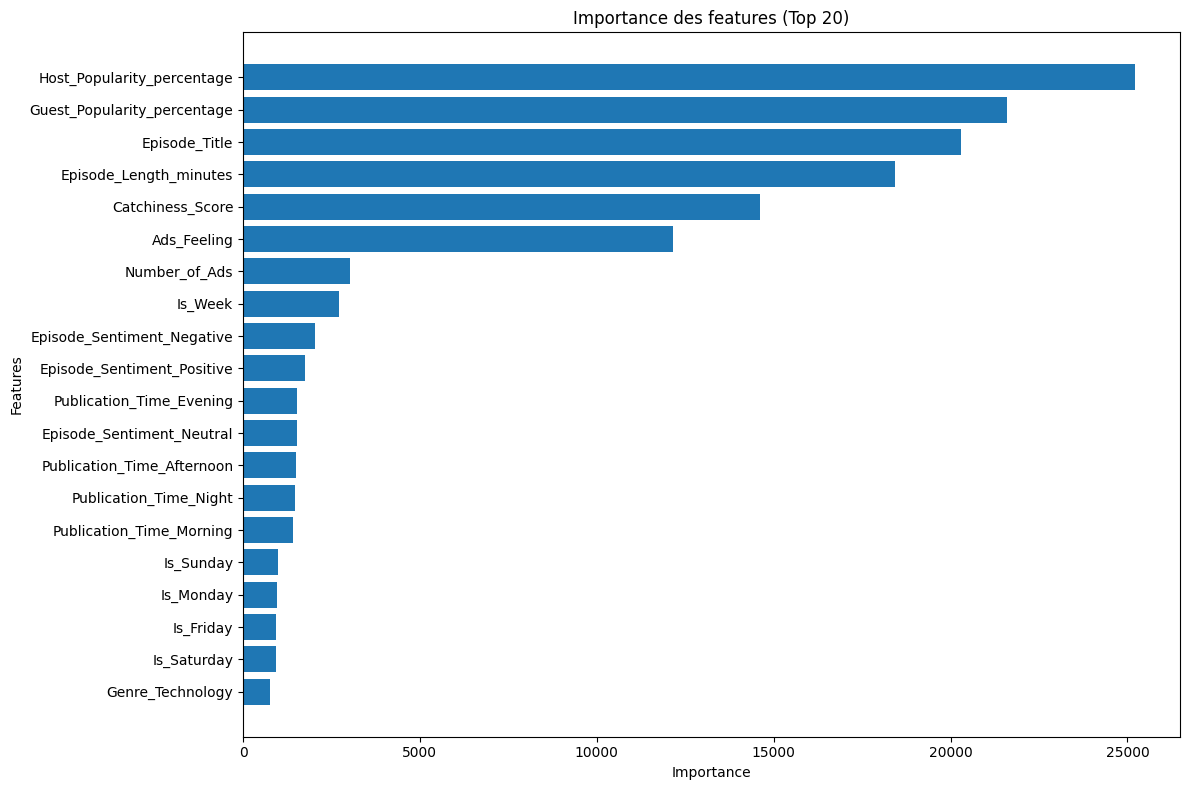

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

feature_importances = best_model.feature_importances_

feature_names = X.columns.tolist()

importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Top 10 features importantes:")
print(importances_df.head(10))

plt.figure(figsize=(12, 8))
plt.barh(importances_df['Feature'][:20], importances_df['Importance'][:20])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Importance des features (Top 20)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [7]:
ids = test['id'].copy()
X_test = test.drop('id', axis=1)
X_test_scaled = x_scaler.transform(X_test)

y_pred_scaled = best_model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

results = pd.DataFrame({
    'id': ids,
    'Listening_Time_minutes': y_pred
})

c:\Users\RINGULARITY\venvs\model_train\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



In [8]:
results.to_csv("./results/4.csv", index=False)

Check RMSE on train set to see the difference

In [9]:
yp = best_model.predict(X_train)
yp = y_scaler.inverse_transform(yp.reshape(-1, 1)).flatten()

np.sqrt(mean_squared_error(invert_transform(y_train), yp))

c:\Users\RINGULARITY\venvs\model_train\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



10.34433935327359